# Homotopic optimal control of interplanetary spacecraft

## Dynamics

In [ ]:
from sympy import *
init_printing()

In [ ]:
# state variables
x, y, z, vx, vy, vz = symbols('x y z v_x v_y v_z', real=True)
m = symbols('m', real=True, nonnegative=True)

# position
p = Matrix([x, y, z])

# velocity
v = Matrix([vx, vy, vz])

# state
s = Matrix([p, v, [m]])
s.T

In [ ]:
# control parameters
um = symbols('u', real=True, positive=True)
ux, uy, uz =symbols('\\hat{u}_x \\hat{u}_y \\hat{u}_z', real=True)
uh = Matrix([ux, uy, uz])
u = Matrix([[um], uh])

# constants
c1, c2, mu = symbols('c_1 c_2 \\mu', real=True, positive=True)
T, isp, mu, g = symbols('T I_{sp} \\mu g_0', real=True, positive=True)
c1 = T
c2 = T/(isp*g)

# equations of motion
ds = Matrix([
    v,
    (-mu/((x**2 + y**2 + z**2)**(Rational(3/2))))*(p) + (c1*um/m)*uh,
    [-c2*um]
])
simplify(ds)

In [ ]:
# homotopy parameter
alpha, beta = symbols('\\alpha \\beta', real=True, nonnegative=True)

# Lagrangian
L = alpha + (1-alpha)*um
L = beta*L + (1-beta)*um**2
L.simplify()

In [ ]:
 # costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True)
l.T

In [ ]:
# Hamiltonian
H = l.dot(ds) + L
H

In [ ]:
# minimise Hamiltonian w.r.t. controls
lv = Matrix(l[3:6])
uhs = -lv/sqrt(sum([var**2 for var in lv]))
simplify(uhs)

In [ ]:
# new Hamiltonian
H1 = H.subs(ux, uhs[0]).subs(uy, uhs[1]).subs(uz, uhs[2])
ums = solve(H1.diff(um), um)[0]
ums.subs(l[3:6,:].norm(), '\\lambda_v')

In [ ]:
us = Matrix([[ums], uhs])
us

In [ ]:
# costate equations of motion
dl = -H.diff(s)
dl

In [ ]:
Matrix([
    ums.subs(alpha, 0).subs(beta, 0),
    ums.subs(alpha, 0).subs(beta, 1),
    ums.subs(alpha, 1).subs(beta, 0),
    ums.subs(alpha, 1).subs(beta, 1),
    ums.subs(alpha, 0),
    ums.subs(alpha, 1),
    ums.subs(beta, 0),
    ums.subs(beta, 1),
    ums
])

In [ ]:
tangent = Matrix([
    (-mu/(p.norm()**3))*p,
    v
])
tangent = tangent/tangent.norm()
l[:-1, :].dot(tangent).simplify()

In [ ]:
ums.subs(alpha, 0).subs(beta, 1).simplify()

## Base trajectory

In [1]:
import sys, numpy as np, matplotlib.pyplot as plt, pygmo as pg, pykep as pk
sys.path.append('../src/')
from spacecraft import Spacecraft
from indirect import Indirect
%matplotlib

Using matplotlib backend: TkAgg


In [2]:
# instantiate problem
seg = Spacecraft(T=0.2, isp=2500, m=1000)

In [3]:
# initial state
s0 = np.hstack((*pk.planet.jpl_lp('earth').eph(pk.epoch(0)), seg.M))

# homotopy parameters
alpha = 0
seg.beta = 0

# duration bounds in days
Tlb = 100
Tub = 500

# costates bounds
lb = 50

# decision vector guess
zg = [379.20912013,   0.93398202,  12.76567896, -45.55493263,  -8.26940351, 49.99989562, 3.00127225, -8.58992837, 8.32972382]

In [4]:
# solve single trajectory
z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)

# solve multiple candidate trajectories in parallel
#zl, fl, feasl = seg.solve_par(s0, alpha, 200, 450, 50, npar=1000)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


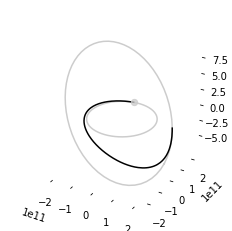

In [5]:
# plot trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
ax = seg.plot_traj(sl, alpha=1)
plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 0$

In [7]:
# homotopy
alpha = 0
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta0 = np.load('spacecraft_z_beta_homotopy_alpha_0.npy'); alpha = 0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


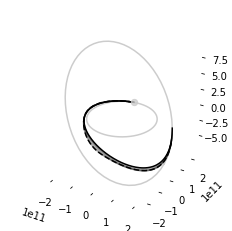

In [8]:
# plot homotopy
for i, t in enumerate(Ta0):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta0) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 1$

In [9]:
# homotopy
alpha = 1
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta1 = np.load('spacecraft_z_beta_homotopy_alpha_1.npy'); alpha = 1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


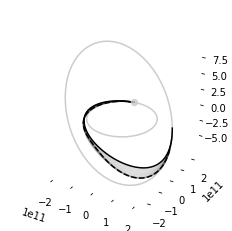

In [10]:
# plot homotopy
for i, t in enumerate(Ta1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

# Policy homotopy in $\alpha \times [0, 1] : \beta = 1$

In [11]:
# homotopy
alpha = 0
alphag = 1
seg.beta = 0.99999
z = Ta0[-1][0]
#Tb1 = seg.homotopy(s0, alpha, Tlb, Tub, lb, z, alphag, step=0.1, verbose=False)
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


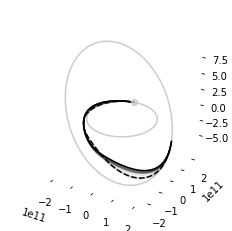

In [12]:
# plot homotopy
for i, t in enumerate(Tb1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    alpha = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Tb1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

## Comparing policy homotopies

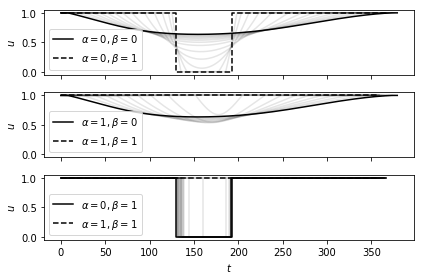

In [13]:
# figure
fig, ax = plt.subplots(3, sharex=True)

alpha = 0
for i, sol in enumerate(Ta0):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta0) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta0) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
    
alpha = 1
for i, sol in enumerate(Ta1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta1) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta1) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
        
seg.beta = 0.999999999
for i, sol in enumerate(Tb1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    alpha = sol[1]
    
    # simulate
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[2].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    elif i == len(Tb1) - 1:
        ax[2].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[2].plot(tl, ul[:,0], "k-", alpha=0.1)
    

ax[2].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$u$')
ax[1].set_ylabel(r'$u$')
ax[2].set_ylabel(r'$u$')
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[2].legend(loc='lower left')
ax[0].set_ylim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.05)
ax[2].set_ylim(-0.05, 1.05)

fig.tight_layout()
#fig.savefig('spacecraft_u_full_homotopy.pdf', bbox_inches='tight')
plt.show()

## Random walks at $\beta = 0$

In [14]:
# decision vector and homotopy parameter
z, seg.beta = Ta0[0]
alpha = 0

# number of serial perturbations per walk
n = 1

# number of walks
nw = 4

In [15]:
# random walks in parallel
T = seg.random_walk_par(s0, z, alpha, n, Tlb, Tub, lb, nw, dsm=0.001, verbose=True)

Success 1. Step sice now 0.001
Success 1. Step sice now 0.001
Success 1. Step sice now 0.001
Success 1. Step sice now 0.001


In [16]:
%matplotlib
# plot random walks
for i, t in enumerate(T):
    s0 = t[0]
    z = t[1]
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.5)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Using matplotlib backend: TkAgg


## Database homotopy $\beta \times [0, 1], \alpha = 0$

In [17]:
res = seg.homotopy_db_beta(T, alpha, beta, Tlb, Tub, lb, betag, step=0.1)
#res = np.load('spacecraft_db_beta_homotopy_a0.npy')

z=[379.92275985   0.95148258  12.54838745 -45.64292822  -8.40140676
  49.94489252   3.17309993  -8.69338929   8.4038828 ]
beta=0
z=[379.87863793   0.95525268  12.55461514 -45.53410204  -8.00617378
  49.86430635   3.26224638  -8.47936516   8.37617334]
beta=0
z=[379.21173836   0.93964791  12.7287667  -45.5859207   -8.07199628
  49.99999525   3.07827807  -8.42763025   8.33979495]
beta=0
z=[379.20912083   0.93398202  12.76567903 -45.55493287  -8.26940349
  49.99989594   3.00127226  -8.58992838   8.32972381]
beta=0
z=[378.23852009   0.92699162  12.75892301 -45.26700079  -8.25905005
  49.67311132   2.75926704  -8.51872788   8.19245771]
beta=0.1
z=[378.18374222   0.93060135  12.76127234 -45.15721818  -7.87506422
  49.58847151   2.85025617  -8.30996217   8.16506891]
beta=0.1
z=[377.57358075   0.91553902  12.93611945 -45.22031996  -7.94271874
  49.73251444   2.66793279  -8.25871026   8.13104363]
beta=0.1
z=[377.55856573   0.9097967   12.97069912 -45.18506421  -8.13523255
  49.72517546   2.59198

beta=0.99278125
z=[ 3.67129606e+02  7.56415116e-01  1.41417939e+01 -4.34873718e+01
 -8.54247496e+00  4.83825842e+01  1.03800318e-01 -9.15394131e+00
  6.81752091e+00]
beta=0.999
Finished
z=[ 3.66816487e+02  7.48509484e-01  1.41755977e+01 -4.34950615e+01
 -8.42168846e+00  4.83945517e+01  1.59445840e-01 -8.94865908e+00
  6.78324017e+00]
beta=0.999
Finished
z=[379.08285847   0.93816793  12.75026402 -45.48112396  -8.27368682
  49.9565021    2.99230739  -8.61100123   8.35226789]
beta=0
z=[ 3.67168835e+02  7.60944087e-01  1.40526934e+01 -4.34200877e+01
 -8.27818758e+00  4.82835226e+01  2.93999378e-01 -9.00126177e+00
  6.80555255e+00]
beta=0.999
Finished
z=[ 3.66647875e+02  7.40814267e-01  1.42396048e+01 -4.34249440e+01
 -8.59948806e+00  4.83638947e+01  3.90951580e-02 -9.08757515e+00
  6.76643474e+00]
beta=0.999
Finished
z=[377.47446822   0.91436761  12.95676889 -45.12061113  -8.14068227
  49.69308915   2.5846065   -8.43769176   8.14419421]
beta=0.1
z=[376.0103156    0.89242281  13.16016885 -4

In [18]:
# plot database homotopy
alpha = 0
for i, r in enumerate(res):
    s0, z, seg.beta = r
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=0.1)
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.1)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


## Database homotopy $\alpha \times [0, 1], \beta = 1$

In [20]:
# get effort optimal trajectories
s0zl = res[np.argwhere(res[:,2] >= 0.999).flatten(), :2]
alpha = 0
alphag = 1
seg.beta == 0.99999
T = seg.homotopy_db(s0zl, alpha, Tlb, Tub, lb, alphag, step=0.01)
#T = np.load('spacecraft_db_alpha_homotopy_beta_1.npy')

z=[ 3.66816487e+02  7.48509484e-01  1.41755977e+01 -4.34950615e+01
 -8.42168846e+00  4.83945517e+01  1.59445840e-01 -8.94865908e+00
  6.78324017e+00]
a=0.0
z=[ 3.67129606e+02  7.56415116e-01  1.41417939e+01 -4.34873718e+01
 -8.54247496e+00  4.83825842e+01  1.03800318e-01 -9.15394131e+00
  6.81752091e+00]
a=0.0
z=[ 3.66647875e+02  7.40814267e-01  1.42396048e+01 -4.34249440e+01
 -8.59948806e+00  4.83638947e+01  3.90951580e-02 -9.08757515e+00
  6.76643474e+00]
a=0.0
z=[ 3.67168835e+02  7.60944087e-01  1.40526934e+01 -4.34200877e+01
 -8.27818758e+00  4.82835226e+01  2.93999378e-01 -9.00126177e+00
  6.80555255e+00]
a=0.0
z=[ 3.66745566e+02  7.47303853e-01  1.42494095e+01 -4.35191432e+01
 -8.35242116e+00  4.84623959e+01  7.96232123e-02 -8.85911056e+00
  6.75064549e+00]
a=0.01
z=[ 3.67060399e+02  7.55226860e-01  1.42135538e+01 -4.35136965e+01
 -8.47147846e+00  4.84515041e+01  2.66841922e-02 -9.06123352e+00
  6.78434624e+00]
a=0.01
z=[ 3.66575596e+02  7.39588132e-01  1.43151752e+01 -4.34537339

a=0.13999999999999999
z=[366.23784886   0.74111156  14.97357775 -43.63816056  -7.59495962
  49.03140668  -0.85879531  -7.93308912   6.37100868]
a=0.12999999999999998
z=[366.21473072   0.74455265  14.93696391 -43.51573936  -7.2988665
  48.91820296  -0.75084398  -7.7244658    6.32329628]
a=0.13999999999999999
z=[365.65174998   0.72392402  15.15772772 -43.56397087  -7.56740278
  49.04422445  -1.02854831  -7.78259559   6.29380622]
a=0.13999999999999999
z=[365.76461065   0.73064452  15.1335207  -43.57493703  -7.34691872
  49.04978748  -0.97875093  -7.58333265   6.27149981]
a=0.15
z=[366.1692597    0.73993416  15.02982895 -43.63555822  -7.52010218
  49.06273719  -0.92970402  -7.83789677   6.33551424]
a=0.13999999999999999
z=[366.14623712   0.74337641  14.99227929 -43.50823691  -7.22677603
  48.94467073  -0.82233092  -7.63179704   6.28767939]
a=0.15
z=[365.5807233    0.72271921  15.21429908 -43.55757635  -7.49142428
  49.07147421  -1.10108483  -7.68801329   6.25870771]
a=0.15
z=[365.69406745 

a=0.2800000000000001
z=[365.16115872   0.72643163  15.69798494 -43.2969655   -6.19337462
  49.16359832  -1.79200148  -6.31663008   5.77969136]
a=0.2900000000000001
z=[364.75276291   0.71343099  15.85083555 -43.35231164  -6.28952328
  49.25706062  -1.96451412  -6.272601     5.76833442]
a=0.2900000000000001
z=[365.19004252   0.7230851   15.73532871 -43.46418194  -6.44818809
  49.31595395  -1.88607272  -6.48890766   5.82716701]
a=0.2800000000000001
z=[364.56278555   0.70541     15.93095123 -43.35291646  -6.40294048
  49.28978774  -2.08142193  -6.34742791   5.75707765]
a=0.2900000000000001
z=[365.08825304   0.72517395  15.74456387 -43.27694376  -6.11799981
  49.17151046  -1.85933338  -6.2215002    5.7429363 ]
a=0.3000000000000001
z=[364.67788826   0.71215348  15.89815208 -43.33153252  -6.21237188
  49.26414615  -2.03289659  -6.17780941   5.73190628]
a=0.3000000000000001
z=[365.11794344   0.72184003  15.78139145 -43.4459134   -6.37011357
  49.32505182  -1.95225309  -6.39146649   5.79031035]

a=0.4300000000000002
z=[364.14174058   0.70488187  16.34379836 -43.17884379  -5.34006056
  49.38416876  -2.79021074  -5.11346218   5.30787872]
a=0.4200000000000002
z=[363.46877651   0.68663875  16.55207913 -43.04727611  -5.27626015
  49.33581632  -3.00783705  -4.98032468   5.24490339]
a=0.4300000000000002
z=[363.57794142   0.69328159  16.52067564 -43.01583587  -5.11322747
  49.30437798  -2.96422306  -4.83672626   5.21840835]
a=0.4400000000000002
z=[364.01740358   0.70659603  16.35758261 -42.97013856  -5.04440416
  49.22209186  -2.77711873  -4.87533967   5.22504547]
a=0.4400000000000002
z=[364.06317321   0.70350696  16.38458716 -43.15720181  -5.25979386
  49.38545212  -2.85293769  -5.01438477   5.27061334]
a=0.4300000000000002
z=[363.38661222   0.6852183   16.59375971 -43.0245718   -5.19460925
  49.33585839  -3.07205176  -4.88184829   5.20815353]
a=0.4400000000000002
z=[363.49508337   0.69184994  16.56256333 -42.9927019   -5.03351171
  49.30430176  -3.02882217  -4.74005294   5.1815799 ]

a=0.5800000000000003
z=[362.89729789   0.68285103  16.92061807 -42.86022215  -4.12497483
  49.37691872  -3.70083038  -3.61968047   4.74898762]
a=0.5700000000000003
z=[362.25660198   0.66546918  17.10384242 -42.73722204  -4.12312958
  49.31498577  -3.87866829  -3.59519206   4.73040162]
a=0.5700000000000003
z=[362.82508054   0.68554579  16.90549977 -42.66349376  -3.94428406
  49.21128398  -3.64220832  -3.50897101   4.70568415]
a=0.5800000000000003
z=[362.25864337   0.67024177  17.1124985  -42.68126167  -3.90577203
  49.28130709  -3.90003169  -3.3787535    4.66625097]
a=0.5900000000000003
z=[362.16432879   0.6638355   17.14046681 -42.71631984  -4.04018383
  49.3122334   -3.93820128  -3.49593702   4.69375079]
a=0.5800000000000003
z=[362.80871652   0.68125795  16.95624795 -42.8401248   -4.04337321
  49.37500246  -3.75887213  -3.51974883   4.71184798]
a=0.5800000000000003
z=[362.73413915   0.68391759  16.94189002 -42.64280374  -3.86509709
  49.20918594  -3.70138077  -3.41097875   4.66871062]

a=0.7200000000000004
z=[360.84849599   0.64475492  17.57422849 -42.4213479   -2.77522949
  49.23630022  -4.68003613  -2.01908259   4.15862891]
a=0.7300000000000004
z=[361.58211594   0.6586946   17.37733148 -42.60423728  -2.98478967
  49.34179481  -4.46891186  -2.22489644   4.2341225 ]
a=0.7100000000000004
z=[360.7777079    0.63873175  17.60124256 -42.45563567  -2.88278948
  49.2650412   -4.71629523  -2.1120014    4.18648492]
a=0.7200000000000004
z=[361.36619217   0.65883759  17.39994199 -42.38665613  -2.75982404
  49.17205705  -4.47449401  -2.04393382   4.15771209]
a=0.7300000000000004
z=[360.74056619   0.64274819  17.60240975 -42.4059732   -2.69568171
  49.23295638  -4.73034485  -1.92305192   4.12315609]
a=0.7400000000000004
z=[361.48191852   0.65679846  17.40581583 -42.58870554  -2.90416714
  49.3390398   -4.51917302  -2.12614329   4.19803108]
a=0.7200000000000004
z=[360.6717472    0.63675843  17.6296003  -42.44008726  -2.80123036
  49.2615722   -4.76674742  -2.01419217   4.15098894]

a=0.8500000000000005
z=[359.25798914   0.60892856  17.91400083 -42.29437659  -1.7828229
  49.23165446  -5.32120556  -0.76825432   3.70798488]
a=0.8600000000000005
z=[360.04572543   0.6277967   17.71555252 -42.43423311  -1.81691541
  49.31793831  -5.11533066  -0.77119927   3.71344378]
a=0.8600000000000005
z=[359.88296934   0.62904542  17.70697058 -42.23093006  -1.71026339
  49.14787264  -5.07105089  -0.71381483   3.67708832]
a=0.8700000000000006
z=[359.19612288   0.61205117  17.89425688 -42.25926854  -1.6281721
  49.20747964  -5.31202447  -0.59796032   3.64590885]
a=0.8800000000000006
z=[359.15173893   0.60662191  17.92797782 -42.28767638  -1.70722403
  49.23134891  -5.35470279  -0.67143618   3.67473414]
a=0.8700000000000006
z=[359.94712666   0.6255526   17.72976043 -42.42818909  -1.74186167
  49.31883547  -5.14863857  -0.67352089   3.67977857]
a=0.8700000000000006
z=[359.78014028   0.62669646  17.72104424 -42.22558768  -1.63642765
  49.14968096  -5.10463216  -0.61496103   3.64287825]
a

a=1.0
Finished
z=[358.9266566    0.60149653  17.95442983 -42.27829076  -1.54361053
  49.23587402  -5.42249234  -0.4573858    3.6020643 ]
a=1.0
Finished
z=[ 3.66608427e+02  7.45036984e-01  1.43637935e+01 -4.34384137e+01
 -8.45981995e+00  4.84933949e+01 -1.08321542e-01 -8.92812360e+00
  6.72468871e+00]
a=0.02
z=[ 3.66535783e+02  7.43811457e-01  1.44361445e+01 -4.34612219e+01
 -8.38773548e+00  4.85586282e+01 -1.87229170e-01 -8.83563691e+00
  6.69198213e+00]
a=0.03
z=[ 3.66463516e+02  7.42592415e-01  1.45064259e+01 -4.34800025e+01
 -8.31525035e+00  4.86187727e+01 -2.65328214e-01 -8.74293378e+00
  6.65895222e+00]
a=0.04
z=[ 3.66391497e+02  7.41377691e-01  1.45749809e+01 -4.34954851e+01
 -8.24239464e+00  4.86747087e+01 -3.42743462e-01 -8.65001884e+00
  6.62565504e+00]
a=0.05
z=[366.31957047   0.74016458  14.64225984 -43.50863032  -8.16920313
  48.72759218  -0.41963845  -8.556894     6.59216436]
a=0.060000000000000005
z=[366.24795861   0.73895683  14.70753545 -43.5178867   -8.09563839
  48.77

a=0.5800000000000003
z=[362.13066608   0.66846859  17.14488725 -42.66711795  -3.96119841
  49.30776273  -3.97524326  -3.40445414   4.67751618]
a=0.5900000000000003
z=[362.03579645   0.6667903   17.18034753 -42.64689775  -3.87815875
  49.30474693  -4.03358906  -3.30481969   4.64081319]
a=0.6000000000000003
z=[361.9400335    0.66509199  17.21536101 -42.62696448  -3.79511516
  49.30164454  -4.09146689  -3.20520447   4.604149  ]
a=0.6100000000000003
z=[361.84336577   0.66337316  17.24989125 -42.60728542  -3.71208096
  49.29840823  -4.14884882  -3.10562099   4.56752512]
a=0.6200000000000003
z=[361.74577822   0.66163324  17.28392277 -42.58787821  -3.62907131
  49.29504953  -4.20571295  -3.00608178   4.53094731]
a=0.6300000000000003
z=[361.64725504   0.65987161  17.31745003 -42.56878637  -3.54610296
  49.29160995  -4.26203955  -2.90659984   4.49442374]
a=0.6400000000000003
z=[361.54778223   0.65808764  17.35046646 -42.55005499  -3.46319411
  49.28813249  -4.31780718  -2.8071891    4.4579632 ]

In [22]:
#np.save('spacecraft_db_alpha_homotopy_beta_1.npy', T)

In [21]:
# plot database homotopy
fig1, ax1 = plt.subplots(1)
for i, r in enumerate(T):
    s0, z, alpha = r
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    ax1.plot(tl, ul[:,0], "k-", alpha=0.1)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=0.1)
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.1)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


## Training a nueral network

In [23]:
from ann import *

In [26]:
# assemble database
#db = seg.gen_db(T, cat=True)
db = np.load('spacecraft_db.npy')
db = db[np.hstack((np.argwhere(db[:,8] == 1).flatten(), np.argwhere(db[:,8] == 0).flatten())), :]

In [25]:
#np.save('spacecraft_db.npy', db)

In [27]:
# get data ready for training 
db = Data(db, [0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11])

In [55]:
# instantiate the neural network
mlp = Spacecraft_Controller([seg.sdim + 1, 40, 40, 40, 4])

In [56]:
mlp.train(db.i, db.o, epo=500, lr=1e-3, ptst=0.1)

Episode 0; Testing Loss 0.3327822321211221; Training Loss 0.3319824239858338
Episode 1; Testing Loss 0.3249928483476679; Training Loss 0.3242050961302826
Episode 2; Testing Loss 0.3177308401010079; Training Loss 0.3169720785906912
Episode 3; Testing Loss 0.31076618427470987; Training Loss 0.3100382900165702
Episode 4; Testing Loss 0.3041097170905423; Training Loss 0.30340116407240575
Episode 5; Testing Loss 0.2977435217625158; Training Loss 0.2970649386521203
Episode 6; Testing Loss 0.291552007951299; Training Loss 0.29090091726134587
Episode 7; Testing Loss 0.28553328669705125; Training Loss 0.28491704038497906
Episode 8; Testing Loss 0.27971404555870777; Training Loss 0.2791296704368529
Episode 9; Testing Loss 0.27386469238532773; Training Loss 0.2733147621638192
Episode 10; Testing Loss 0.26803335292744; Training Loss 0.2675082268843441
Episode 11; Testing Loss 0.26215326178510745; Training Loss 0.26165727376151127
Episode 12; Testing Loss 0.2562187788763069; Training Loss 0.2557464

Episode 103; Testing Loss 0.03415798450171125; Training Loss 0.03405235145039352
Episode 104; Testing Loss 0.03406389063426876; Training Loss 0.033958999455143454
Episode 105; Testing Loss 0.03397007915748959; Training Loss 0.033866157367840224
Episode 106; Testing Loss 0.03387672158454821; Training Loss 0.03377342589764871
Episode 107; Testing Loss 0.03378346459577185; Training Loss 0.03368067137962874
Episode 108; Testing Loss 0.03369062889345039; Training Loss 0.033587959543772465
Episode 109; Testing Loss 0.033598904759803254; Training Loss 0.033495199335712114
Episode 110; Testing Loss 0.03350877278410838; Training Loss 0.03340301853097764
Episode 111; Testing Loss 0.033421430411041654; Training Loss 0.03331250778457989
Episode 112; Testing Loss 0.033337268629776144; Training Loss 0.03322485384145039
Episode 113; Testing Loss 0.03325553741204873; Training Loss 0.03313935637513241
Episode 114; Testing Loss 0.03317568621130132; Training Loss 0.03305583168769212
Episode 115; Testing 

Episode 204; Testing Loss 0.03002856189554581; Training Loss 0.0298716748296565
Episode 205; Testing Loss 0.030013207441477206; Training Loss 0.029855977196126354
Episode 206; Testing Loss 0.029997580169858328; Training Loss 0.02983982836334113
Episode 207; Testing Loss 0.029981510178445827; Training Loss 0.02982310434685818
Episode 208; Testing Loss 0.029964896303182297; Training Loss 0.029805688266527457
Episode 209; Testing Loss 0.02994744716235278; Training Loss 0.029787444479483265
Episode 210; Testing Loss 0.029928806280975464; Training Loss 0.029768115077527343
Episode 211; Testing Loss 0.029908840287992264; Training Loss 0.02974737029786499
Episode 212; Testing Loss 0.029886933634524483; Training Loss 0.029724789631159546
Episode 213; Testing Loss 0.029862418292022748; Training Loss 0.029699684971286815
Episode 214; Testing Loss 0.029834199414873846; Training Loss 0.0296710553059514
Episode 215; Testing Loss 0.02980108627978425; Training Loss 0.029637333034517477
Episode 216; T

Episode 304; Testing Loss 0.023099814491879846; Training Loss 0.02256025801469039
Episode 305; Testing Loss 0.022677799193138275; Training Loss 0.02223963685185544
Episode 306; Testing Loss 0.022705424439090557; Training Loss 0.022306862053893428
Episode 307; Testing Loss 0.022951656009371744; Training Loss 0.02239377780215904
Episode 308; Testing Loss 0.02253177118100491; Training Loss 0.022052680379398032
Episode 309; Testing Loss 0.022602257563745766; Training Loss 0.02223289782443334
Episode 310; Testing Loss 0.022868662471023316; Training Loss 0.022313386165410187
Episode 311; Testing Loss 0.022417964699983195; Training Loss 0.02189906401292186
Episode 312; Testing Loss 0.022654820701377486; Training Loss 0.02226272786253426
Episode 313; Testing Loss 0.02262932947415794; Training Loss 0.02206983541577806
Episode 314; Testing Loss 0.022447674801606365; Training Loss 0.021907162586139162
Episode 315; Testing Loss 0.022478635707529827; Training Loss 0.022073767241959783
Episode 316; 

Episode 404; Testing Loss 0.020631529645248274; Training Loss 0.02005650186231409
Episode 405; Testing Loss 0.02061825553714656; Training Loss 0.020045035257730135
Episode 406; Testing Loss 0.02061097819927683; Training Loss 0.020033700768521324
Episode 407; Testing Loss 0.020594825301945584; Training Loss 0.02002251726117058
Episode 408; Testing Loss 0.020590909124072448; Training Loss 0.020011557611140318
Episode 409; Testing Loss 0.02057016703836316; Training Loss 0.020001060863086784
Episode 410; Testing Loss 0.020576836981671533; Training Loss 0.019991064110402804
Episode 411; Testing Loss 0.0205482490970273; Training Loss 0.019981181609872223
Episode 412; Testing Loss 0.020565836828122474; Training Loss 0.019972113863708837
Episode 413; Testing Loss 0.020526290162807957; Training Loss 0.019963989541285865
Episode 414; Testing Loss 0.020556532773504714; Training Loss 0.01995618293340435
Episode 415; Testing Loss 0.020504424665974685; Training Loss 0.01995004474103894
Episode 416; 

In [57]:
fig, ax = plt.subplots(1)
ax.plot(mlp.ltrn, "k-")
ax.plot(mlp.ltst, "k--")
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
#ax.set_xscale('log')
plt.show()

## Neural network accuracy

In [58]:
# alpha homotopy
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy'); seg.beta = 0.99999

# effort optimal base
z = Tb1[0][0]
alpha = 0
tl0, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
a0i = np.hstack((sl[:,:seg.sdim], np.full((len(sl), 1), alpha)))
a0o = ul
a0op = mlp(torch.from_numpy(a0i)).detach().numpy()

# time optimal base
z = Tb1[-1][0]
alpha = 1
tl1, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
a1i = np.hstack((sl[:,:seg.sdim], np.full((len(sl), 1), alpha)))
a1o = ul
a1op = mlp(torch.from_numpy(a1i)).detach().numpy()

In [59]:
# plot
fig, ax = plt.subplots(4, 2, sharex=True, sharey=False)
for i in range(4):
    ax[i][0].plot(tl0, a0o[:, i], "k--")
    ax[i][1].plot(tl1, a1o[:, i], "k--")
    ax[i][0].plot(tl0, a0op[:, i], "k-")
    ax[i][1].plot(tl1, a1op[:, i], "k-")
    if i == 0:
        ax[i][0].set_ylim(-0.1, 1.1)
        ax[i][1].set_ylim(-0.1, 1.1)
    else:
        ax[i][0].set_ylim(-1.1, 1.1)
        ax[i][1].set_ylim(-1.1, 1.1)

fig.tight_layout()
plt.show()

In [ ]:
a1i[0]